# Predicting the Sale Price of Bulldozers using Machine Learning

In this notebook, we're going through a machine learning project with the goal of predicting the sale price of bulldozers.

## 1. Problem definition

> How well can we predict the future sale price of a bulldozer,  given its characteristics and previous examples of how much similar bulldozers have been sold for? 

## 2. Data

Data is downloaded from the Kaggle bluebook for bulldozer competition : https://www.kaggle.com/competitions/bluebook-for-bulldozers/data

The data for this competition is split into three parts:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

The key fields are in train.csv are:

SalesID: the uniue identifier of the sale
MachineID: the unique identifier of a machine.  A machine can be sold multiple times
saleprice: what the machine sold for at auction (only provided in train.csv)
saledate: the date of the sale

## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check: https://www.kaggle.com/competitions/bluebook-for-bulldozers/overview/evaluation

**Note:** The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimise RMSLE.

## 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset. You can view this data dictionary by visiting this link: https://www.kaggle.com/competitions/bluebook-for-bulldozers/data


In [8]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import sklearn

In [2]:
# importing training and validation sets
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv",
                low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [4]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

In [5]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

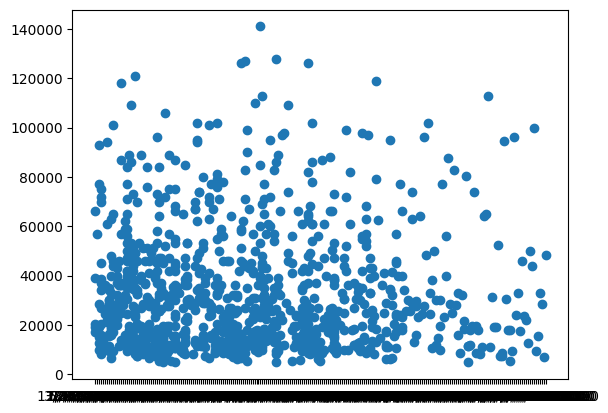

In [6]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000]);

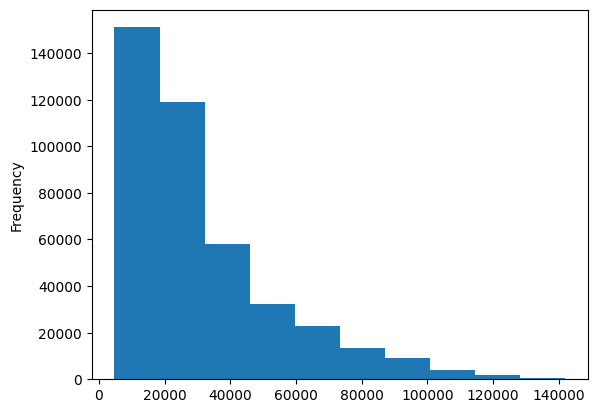

In [7]:
df["SalePrice"].plot.hist();

### Parsing dates

When we work with time series data, we want to enrich the time and date component as much as posible.

We can do that by telling pandas which of our columns has dates in it using the `parse_dates` parameter.

In [8]:
# Import data again 
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv",
                low_memory = False,
                parse_dates = ["saledate"])

In [9]:
df.saledate[:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

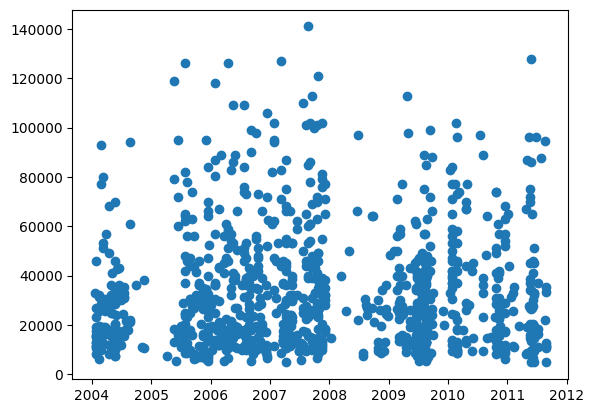

In [10]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000]);

In [11]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Transpose the head to get a look at all the columns as in original view some are truncated
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [13]:
df.saledate.head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

### Sort DataFrame by saledate

When working with time series data, it's a good idea to sort it by date.

In [14]:
# Sort DataFrae=me in date order
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head()

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of the original DataFrame

We make a copy of the original dataframe so when we manipulate the copy, we've still got our original data.

In [15]:
df_temp = df.copy()

In [16]:
df_temp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN


In [17]:
df1 = df_temp.sort_values(by = ["SalePrice"], ascending=True)
df1.SalePrice.head(10)

259283    4750.0
374724    4750.0
12945     4750.0
23498     4750.0
377383    4750.0
411468    4750.0
259425    4750.0
286949    4750.0
27803     4750.0
390604    4750.0
Name: SalePrice, dtype: float64

### Add datetime parameters for `saledate` column

In [18]:
df_temp["saleYear"] = df_temp.saledate.dt.year
df_temp["saleMonth"] = df_temp.saledate.dt.month
df_temp["saleDay"] = df_temp.saledate.dt.day
df_temp["saleDayOfWeek"] = df_temp.saledate.dt.day_of_week
df_temp["saleDayOfYear"] = df_temp.saledate.dt.day_of_year

In [19]:
df_temp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [20]:
# Now we've enriched our DataFrame with date time features, we can remove saledate
df_temp.drop("saledate", axis= 1, inplace= True)

In [21]:
# Check the values of different columns

df_temp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

## 5. Modelling

We've done enough EDA (we could always do more) but let's start to do some model-driven EDA.

In [24]:
# Let's build a machine learning model.
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1, random_state=42)

model.fit(df_temp.drop("SalePrice", axis=1), df_temp["SalePrice"])

ValueError: could not convert string to float: 'Low'

### Convert string to categories

One way we can turn all of our data into numbers is by converting them into pandas categories. 

In [25]:
# Find the columns which contain strings

for label, content in df_temp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)


UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [28]:
# This will turn all of the string value into category values
for label, content in df_temp.items():
    if pd.api.types.is_string_dtype(content):
        df_temp[label] = content.astype("category").cat.as_ordered()

In [31]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [33]:
df_temp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [34]:
df_temp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

Thanks to pandas categories we now have a way to access all of our data in the form of numbers. 

But we still have a bunch of missing data...

In [35]:
# Check missing data
df_temp.isnull().sum() / len(df_temp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

### Save preprocessed data 

In [1]:
# Export current temp dataframe
df_temp.to_csv("data/bluebook-for-bulldozers/train_temp.csv", index=False)

NameError: name 'df_temp' is not defined

In [12]:
# Import preprocessed data 
df_temp = pd.read_csv("data/bluebook-for-bulldozers/train_temp.csv", low_memory=False)
df_temp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
0,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
1,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
2,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
3,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
4,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31


## Fill missing values

### Fill numeric missing values first

In [13]:
for label, content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayOfYear


In [14]:
# Check for which numeric columns have null values
for label,content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [15]:
# Fill numeric rows with the median
for label, content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing
            df_temp[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median
            df_temp[label] = content.fillna(content.median())

In [16]:
for label, content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [17]:
df_temp["auctioneerID_is_missing"].value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

In [18]:
df_temp.isnull().sum() / len(df_temp)

SalesID                                0.000000
SalePrice                              0.000000
MachineID                              0.000000
ModelID                                0.000000
datasource                             0.000000
auctioneerID                           0.000000
YearMade                               0.000000
MachineHoursCurrentMeter               0.000000
UsageBand                              0.821492
fiModelDesc                            0.000000
fiBaseModel                            0.000000
fiSecondaryDesc                        0.340993
fiModelSeries                          0.857845
fiModelDescriptor                      0.818715
ProductSize                            0.524851
fiProductClassDesc                     0.000000
state                                  0.000000
ProductGroup                           0.000000
ProductGroupDesc                       0.000000
Drive_System                           0.740520
Enclosure                              0

### Filling and turning categorical variables into numbers

In [19]:
# Check for columns which are'nt numeric
for label, content in df_temp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [20]:
for label, content in df_temp.items():
    if pd.api.types.is_string_dtype(content):
        df_temp[label] = content.astype("category").cat.as_ordered()

In [21]:
# Turn categorical varibales into numbers and fill missing
for label, content in df_temp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add a binary column to indicate whether the sample had missing value
        df_temp[label + "is_missing"] = pd.isnull(content)
        # Turn categories into numbers and add + 1
        df_temp[label] = pd.Categorical(content).codes + 1

In [22]:
df_temp.isnull().sum()

SalesID                        0
SalePrice                      0
MachineID                      0
ModelID                        0
datasource                     0
                              ..
Backhoe_Mountingis_missing     0
Blade_Typeis_missing           0
Travel_Controlsis_missing      0
Differential_Typeis_missing    0
Steering_Controlsis_missing    0
Length: 103, dtype: int64

 Now that all of data is numeric as well as our dataframe has no missing values, we should be able to build a machine learning model.

In [68]:
%%time

from sklearn.ensemble import RandomForestRegressor

# Instantiate model 
model = RandomForestRegressor(n_jobs=-1, random_state=42)

# Fit the model
model.fit(df_temp.drop("SalePrice", axis = 1), df_temp["SalePrice"])

CPU times: user 25min 1s, sys: 13.7 s, total: 25min 15s
Wall time: 8min


RandomForestRegressor(n_jobs=-1, random_state=42)

In [69]:
model.score(df_temp.drop("SalePrice", axis = 1), df_temp["SalePrice"])

0.9875468079970562

### Splitting data into train/validation sets

In [23]:
df_temp.saleYear

0         1989
1         1989
2         1989
3         1989
4         1989
          ... 
412693    2012
412694    2012
412695    2012
412696    2012
412697    2012
Name: saleYear, Length: 412698, dtype: int64

In [71]:
df_temp.saleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

In [24]:
# Split data into training and validation
df_val = df_temp[df_temp.saleYear == 2012]
df_train = df_temp[df_temp.saleYear != 2012]

len(df_val), len(df_train)

(11573, 401125)

In [25]:
# Split data into X & y
X_train, y_train = df_train.drop("SalePrice", axis = 1), df_train.SalePrice
X_valid, y_valid = df_val.drop("SalePrice", axis = 1), df_val.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

### Building an evaluation function

In [26]:
# Create an evaluation function
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    """
    Calculates root mean squared log error between predictios and true labels. 
    """

    return np.sqrt(mean_squared_log_error(y_true=y_test, y_pred=y_preds))

# Create function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
                "Valid MAE": mean_absolute_error(y_valid, val_preds),
                "Training RMSLE": rmsle(y_train, train_preds),
                "Valid RMSLE": rmsle(y_valid, val_preds),
                "Training r2": r2_score(y_train, train_preds),
                "Valid r2": r2_score(y_valid, val_preds)}
    
    return scores


### Testing our model on a subset (to tune the hyperparameters)

In [27]:
# This takes too long... for experimenting 
# model = RandomForestRegressor(n_jobs= -1, random_state=42)
#  model.fit(X_train, y_train)

In [29]:
# Change max_sample value
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_jobs= -1, 
                              random_state=42, 
                              max_samples=10000)

In [30]:
%%time
# Cutting down on the max number of samples each estimator can see improves training time
model.fit(X_train, y_train)

CPU times: user 59.4 s, sys: 1.44 s, total: 1min
Wall time: 27 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [31]:
show_scores(model)

{'Training MAE': 5561.2988092240585,
 'Valid MAE': 7177.26365505919,
 'Training RMSLE': 0.257745378256977,
 'Valid RMSLE': 0.29362638671089003,
 'Training r2': 0.8606658995199189,
 'Valid r2': 0.8320374995090507}

### Hyperparameter tuning with RandomizedSearchCV

In [32]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameter

rf_grid = {"n_estimators": np.arange(10,100,10),
            "max_depth": [None, 3, 5,10],
            "min_samples_split": np.arange(2,20,2),
            "min_samples_leaf": np.arange(1,20,2),
            "max_features":[0.5, 1, "sqrt", "auto"],
            "max_samples": [10000]}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, 
                                                    random_state=42),
                                param_distributions = rf_grid,
                                n_iter = 2,
                                cv = 5,
                                verbose = True)

# Fit the RandomizedSearchCV
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: user 44 s, sys: 9.73 s, total: 53.8 s
Wall time: 1min 4s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [33]:
# Find the best model hyperparameters
rs_model.best_params_

{'n_estimators': 60,
 'min_samples_split': 14,
 'min_samples_leaf': 9,
 'max_samples': 10000,
 'max_features': 1,
 'max_depth': None}

In [34]:
# Evaluate the RandomizedSearchCV model
show_scores(rs_model)

{'Training MAE': 11551.001401354426,
 'Valid MAE': 13676.324802904672,
 'Training RMSLE': 0.5006974301452601,
 'Valid RMSLE': 0.5245314657207272,
 'Training r2': 0.5014597621535439,
 'Valid r2': 0.47605633550961146}

### Train a model with the best hyperparameters

**Note**: These were found after 100 iterations of `RandomizedSearchCV`.

In [35]:
%%time

# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=40, 
                                    min_samples_leaf = 1,
                                    min_samples_split = 14,
                                    max_features = 0.5, 
                                    n_jobs = -1,
                                    max_samples = None,
                                    random_states = 42)

# Fit the ideal model
ideal_model.fit(X_train, y_train) 

CPU times: user 5min 41s, sys: 4 s, total: 5min 45s
Wall time: 2min 13s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1)

In [36]:
# Scores for ideal model (trained on all data)
show_scores(ideal_model)

{'Training MAE': 2959.4988480469615,
 'Valid MAE': 5985.873328991029,
 'Training RMSLE': 0.14484567496755868,
 'Valid RMSLE': 0.24756084569326336,
 'Training r2': 0.9586998560749691,
 'Valid r2': 0.8808945554107251}

In [37]:
# Scores for model (trained on 10000 samples)
show_scores(model)

{'Training MAE': 5561.2988092240585,
 'Valid MAE': 7177.26365505919,
 'Training RMSLE': 0.257745378256977,
 'Valid RMSLE': 0.29362638671089003,
 'Training r2': 0.8606658995199189,
 'Valid r2': 0.8320374995090507}

## Make predictions on test data

In [38]:
# Import the test data
df_test = pd.read_csv("data/bluebook-for-bulldozers/Test.csv", 
                        low_memory=False,
                        parse_dates=["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [39]:
# Make predictions on the test dataset
ideal_model.predict(df_test)

/home/ayushmaan/.local/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- saledate
Feature names seen at fit time, yet now missing:
- Backhoe_Mountingis_missing
- Blade_Extensionis_missing
- Blade_Typeis_missing
- Blade_Widthis_missing
- Coupler_Systemis_missing
- ...

  warnings.warn(message, FutureWarning)


ValueError: could not convert string to float: 'Low'

In [41]:
df_test.isna().sum()

SalesID                         0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                    0
YearMade                        0
MachineHoursCurrentMeter    10328
UsageBand                   10623
saledate                        0
fiModelDesc                     0
fiBaseModel                     0
fiSecondaryDesc              3975
fiModelSeries               10451
fiModelDescriptor            9433
ProductSize                  6409
fiProductClassDesc              0
state                           0
ProductGroup                    0
ProductGroupDesc                0
Drive_System                 9698
Enclosure                       2
Forks                        6149
Pad_Type                    10349
Ride_Control                 8216
Stick                       10349
Transmission                 7639
Turbocharged                10349
Blade_Extension             11806
Blade_Width                 11806
Enclosure_Type

In [42]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SalesID                   12457 non-null  int64         
 1   MachineID                 12457 non-null  int64         
 2   ModelID                   12457 non-null  int64         
 3   datasource                12457 non-null  int64         
 4   auctioneerID              12457 non-null  int64         
 5   YearMade                  12457 non-null  int64         
 6   MachineHoursCurrentMeter  2129 non-null   float64       
 7   UsageBand                 1834 non-null   object        
 8   saledate                  12457 non-null  datetime64[ns]
 9   fiModelDesc               12457 non-null  object        
 10  fiBaseModel               12457 non-null  object        
 11  fiSecondaryDesc           8482 non-null   object        
 12  fiModelSeries     

### Preprocessing the data [getting the test dataset in the same format as our training dataset]

In [43]:
def preprocess_data(df):
    """Performs transformations on df and returns transformed df
    """
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayOfYear"] = df.saledate.dt.dayofyear

    df.drop("saledate", axis = 1, inplace = True)

    # Fill the numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing
                df[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median
                df[label] = content.fillna(content.median())
    # Fill categorical missing data and turn categories into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            df[label] = pd.Categorical(content).codes+1

    return df

In [46]:
preprocess_data(df_test)
df_test.head()

AttributeError: 'DataFrame' object has no attribute 'saledate'

In [45]:
# Process the test data
ideal_model.predict(df_test)

/home/ayushmaan/.local/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Backhoe_Mounting_is_missing
- Blade_Extension_is_missing
- Blade_Type_is_missing
- Blade_Width_is_missing
- Coupler_System_is_missing
- ...
Feature names seen at fit time, yet now missing:
- Backhoe_Mountingis_missing
- Blade_Extensionis_missing
- Blade_Typeis_missing
- Blade_Widthis_missing
- Coupler_Systemis_missing
- ...

  warnings.warn(message, FutureWarning)


ValueError: X has 101 features, but RandomForestRegressor is expecting 102 features as input.

In [47]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'Backhoe_Mountingis_missing',
 'Blade_Extensionis_missing',
 'Blade_Typeis_missing',
 'Blade_Widthis_missing',
 'Coupler_Systemis_missing',
 'Coupleris_missing',
 'Differential_Typeis_missing',
 'Drive_Systemis_missing',
 'Enclosure_Typeis_missing',
 'Enclosureis_missing',
 'Engine_Horsepoweris_missing',
 'Forksis_missing',
 'Grouser_Tracksis_missing',
 'Grouser_Typeis_missing',
 'Hydraulics_Flowis_missing',
 'Hydraulicsis_missing',
 'Pad_Typeis_missing',
 'Pattern_Changeris_missing',
 'ProductGroupDescis_missing',
 'ProductGroupis_missing',
 'ProductSizeis_missing',
 'Pushblockis_missing',
 'Ride_Controlis_missing',
 'Ripperis_missing',
 'Scarifieris_missing',
 'Steering_Controlsis_missing',
 'Stick_Lengthis_missing',
 'Stickis_missing',
 'Thumbis_missing',
 'Tip_Controlis_missing',
 'Tire_Sizeis_missing',
 'Track_Typeis_missing',
 'Transmissionis_missing',
 'Travel_Controlsis_missing',
 'Turbochargedis_missing',
 'Undercarriage_Pad_Widthis_missing',
 'UsageBandis_missing',
 'auction

In [48]:
set(df_test.columns) - set(X_train.columns)

{'Backhoe_Mounting_is_missing',
 'Blade_Extension_is_missing',
 'Blade_Type_is_missing',
 'Blade_Width_is_missing',
 'Coupler_System_is_missing',
 'Coupler_is_missing',
 'Differential_Type_is_missing',
 'Drive_System_is_missing',
 'Enclosure_Type_is_missing',
 'Enclosure_is_missing',
 'Engine_Horsepower_is_missing',
 'Forks_is_missing',
 'Grouser_Tracks_is_missing',
 'Grouser_Type_is_missing',
 'Hydraulics_Flow_is_missing',
 'Hydraulics_is_missing',
 'Pad_Type_is_missing',
 'Pattern_Changer_is_missing',
 'ProductGroupDesc_is_missing',
 'ProductGroup_is_missing',
 'ProductSize_is_missing',
 'Pushblock_is_missing',
 'Ride_Control_is_missing',
 'Ripper_is_missing',
 'Scarifier_is_missing',
 'Steering_Controls_is_missing',
 'Stick_Length_is_missing',
 'Stick_is_missing',
 'Thumb_is_missing',
 'Tip_Control_is_missing',
 'Tire_Size_is_missing',
 'Track_Type_is_missing',
 'Transmission_is_missing',
 'Travel_Controls_is_missing',
 'Turbocharged_is_missing',
 'Undercarriage_Pad_Width_is_missing

In [49]:
# Manually adjust df_test to have auctioneerID_is_missing column
df_test["auctioneerID_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


Finally now our test dataframe has the same features as our training dataframe, we can make predictions!

In [50]:
test_preds = ideal_model.predict(df_test)

/home/ayushmaan/.local/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Backhoe_Mounting_is_missing
- Blade_Extension_is_missing
- Blade_Type_is_missing
- Blade_Width_is_missing
- Coupler_System_is_missing
- ...
Feature names seen at fit time, yet now missing:
- Backhoe_Mountingis_missing
- Blade_Extensionis_missing
- Blade_Typeis_missing
- Blade_Widthis_missing
- Coupler_Systemis_missing
- ...

  warnings.warn(message, FutureWarning)


In [52]:
# Format predictions into the same format Kaggle is after
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds.head()

,SalesID,SalesPrice
0,1227829,22242.639821
1,1227844,19152.152976
2,1227847,48498.072783
3,1227848,57775.766126
4,1227863,39147.729148


In [53]:
# export prediction data to csv
df_preds.to_csv("data/bluebook-for-bulldozers/test_predictions.csv")

### Feature importance

Feature importance seeks to figure out which different attributes of the data were most important when it comes to predicting the target variable(here, SalePrice). 

In [54]:
# Find feature importance of our best model
ideal_model.feature_importances_

array([3.38903404e-02, 1.88148661e-02, 4.68118408e-02, 1.72580595e-03,
       3.29762529e-03, 1.94987733e-01, 2.94307663e-03, 9.63851536e-04,
       4.15505010e-02, 5.22964418e-02, 6.92919781e-02, 5.05654153e-03,
       1.73391535e-02, 1.51631002e-01, 4.16650463e-02, 6.02753946e-03,
       3.23064997e-03, 2.55210104e-03, 3.28565940e-03, 7.68254704e-02,
       5.55197894e-04, 2.08160994e-04, 1.04878366e-03, 4.15106262e-04,
       9.31556385e-04, 3.56901914e-05, 5.87949547e-05, 7.34128976e-03,
       4.73642854e-03, 3.19025635e-04, 3.93985560e-03, 1.52617380e-03,
       4.96709312e-03, 1.22399158e-03, 2.58432040e-04, 7.52214382e-03,
       8.56549902e-04, 6.67217107e-03, 1.20453855e-04, 2.02758849e-03,
       1.60777580e-03, 9.96051044e-04, 1.06004805e-03, 5.96952226e-04,
       4.94504860e-04, 3.46234570e-04, 4.22640442e-04, 1.79479680e-03,
       9.91332205e-04, 3.21813928e-04, 1.95731320e-04, 7.29619843e-02,
       3.78424256e-03, 5.65404291e-03, 2.91447650e-03, 9.91804973e-03,
      

In [63]:
# Helper function for plotting feature importance
def plot_features(columns, importance, n=30):
    df = (pd.DataFrame({"features":columns, 
                        "feature_importances":importance})
                        .sort_values("feature_importances", ascending=False)
                        .reset_index(drop=True))
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:30])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

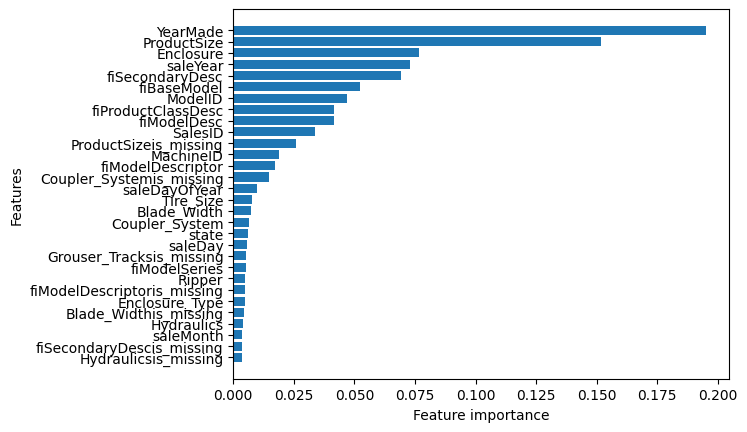

In [64]:
plot_features(X_train.columns, ideal_model.feature_importances_)

Future challenges: What other machine learning models could you try on our dataset?

Hint: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html : Check out the regression section of this map, or try to look at something like CatBoost.ai, XGBoost.ai.